### EEG raw data preprocess
- Use MNE-python to build the preprocess pipeline.
- Band-pass filter at 0.1-30hz
- Resample the raw data to 1000hz
- Automatically reject any epoch whose peak-to-peak value larger than 200e-6v
- Save the preprocessed epoch data as MNE '.fif' file

In [2]:
import mne
from mne import find_events, Epochs, pick_types, read_evokeds
import pandas as pd
import numpy as np

ch_name_dic ={'EEG001': 'PO9', 'EEG002': 'Fpz', 'EEG003': 'PO10', 'EEG004': 'AF7', 
              'EEG005': 'AF3', 'EEG006': 'AFz', 'EEG007': 'AF4', 'EEG008': 'AF8', 'EEG009': 'F7', 
              'EEG010': 'F5', 'EEG011': 'F3', 'EEG012': 'F1', 'EEG013': 'Fz', 'EEG014': 'F2', 
              'EEG015': 'F4', 'EEG016': 'F6', 'EEG017': 'F8', 'EEG018': 'FT9', 'EEG019': 'FT7', 
              'EEG020': 'FC5', 'EEG021': 'FC3', 'EEG022': 'FC1', 'EEG023': 'FCz', 'EEG024': 'FC2', 
              'EEG025': 'FC4', 'EEG026': 'FC6', 'EEG027': 'FT8', 'EEG028': 'FT10', 'EEG029': 'T9', 
              'EEG030': 'T7', 'EEG031': 'C5', 'EEG032': 'C3', 'EEG033': 'C1', 'EEG034': 'Cz', 
              'EEG035': 'C2', 'EEG036': 'C4', 'EEG037': 'C6', 'EEG038': 'T8', 'EEG039': 'T10', 
              'EEG040': 'TP9', 'EEG041': 'TP7', 'EEG042': 'CP5', 'EEG043': 'CP3', 'EEG044': 'CP1', 
              'EEG045': 'CPz', 'EEG046': 'CP2', 'EEG047': 'CP4', 'EEG048': 'CP6', 'EEG049': 'TP8', 
              'EEG050': 'TP10', 'EEG051': 'P9', 'EEG052': 'P7', 'EEG053': 'P5', 'EEG054': 'P3', 
              'EEG055': 'P1', 'EEG056': 'Pz', 'EEG057': 'P2', 'EEG058': 'P4', 'EEG059': 'P6', 
              'EEG060': 'P8', 'EEG065': 'P10', 'EEG066': 'PO7', 'EEG067': 'PO3', 'EEG068': 'POz',  
              'EEG069': 'PO4', 'EEG070': 'PO8', 'EEG071': 'O1', 'EEG072': 'Oz', 'EEG073': 'O2', 'EEG074': 'Iz'}
                
event_id = {'Famous':1,'Unfamiliar':2,'Scrambled':3} 

for subID in range(1,17):
    path = f'/Users/ds000117_R1.0.0/sub-{subID:03}/ses-meg/meg'
    for runID in range(1,7):
        raw = mne.io.read_raw_fif(f'{path}/sub-{subID:03}_ses-meg_task-facerecognition_run-{runID:02}_meg.fif',preload=True)
        raw.set_channel_types({'EEG061':'eog','EEG062':'eog','EEG063':'ecg','EEG064':'misc'})
        # raw.plot(block=True)
        events = mne.find_events(raw,stim_channel='STI101',shortest_event=1)  
        events = mne.merge_events(events,[5,6,7],1)
        events = mne.merge_events(events,[13,14,15],2)
        events = mne.merge_events(events,[17,18,19],3)

        picks = mne.pick_types(raw.info,meg=False,eeg=True,stim=False,eog=False,ecg=False,misc=False)
        raw.filter(0.1,30,n_jobs=2,fir_design='firwin')

        epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.6, picks=picks,
                            baseline=(-0.2, 0), reject=None, preload=True)
        # epoch_raw.drop_channels(['EEG061','EEG062','EEG063','EEG064'])
        epochs.resample(1000.00)
        epochs.rename_channels(ch_name_dic)
        # epochs.plot(block=True)
        # epochs.info['bads'] = ['EEG061','EEG062','EEG063','EEG064']
        # epochs.interpolate_bads(reset_bads=True, mode='accurate', verbose=None)
        epochs.set_eeg_reference(ref_channels='average', projection=True)
        epochs.apply_proj()

        eeg_reject = dict(eeg=200e-6)
        epochs.drop_bad(reject=eeg_reject, flat=None, verbose=None)

        epochs.save(f'/Users/preprocessed/sub-{subID}-run-{runID}-eeg-epo.fif')

### Epoch data loading and saving
- Load the preporcessed epoch data
- Save them into one '.h5' (HDF5) file
- '.h5' file's loading is sufficiently faster than loading multiple '.fif' files

In [1]:
import easyEEG
path = '/Users/preprocessed/'
fif_list = [f'{path}sub-{subID}-run-{runID}-eeg-epo.fif'
              for subID in range(1,17) for runID in range(1,7)]

epochs = easyEEG.io.load_mne_fif(fif_list)
epochs.save('DATAS/EasyEEG_paper/data.h5')

### Epoch data loading

In [1]:
import easyEEG
epochs = easyEEG.io.load_epochs('DATAS/EasyEEG_paper/data.h5') # the file is 6GB, please contach us if you need it

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


EasyEEG loaded.
reading 1
reading 10
reading 11
reading 12
reading 13
reading 14
reading 15
reading 16
reading 2
reading 3
reading 4
reading 5
reading 6
reading 7
reading 8
reading 9
Concatenated.


### Topographic differences
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the topographic differences
- Save the calculated result data into '.pickle' file
- Plot the result data

Your file have been added ".pickle" as the extension name.
Result saved.


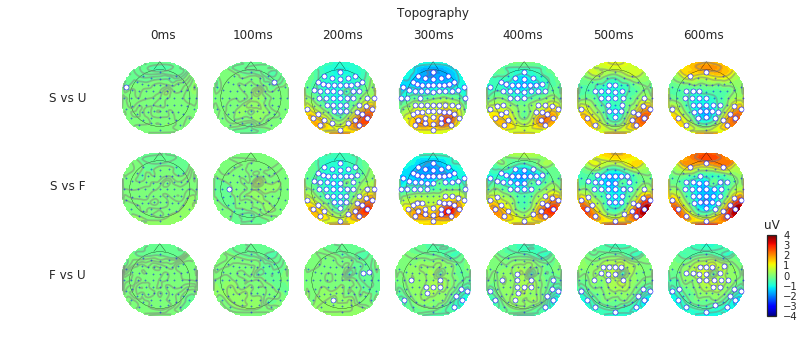

<Figure size 432x288 with 0 Axes>

In [4]:
script = {'conditions': 'S vs U:Scrambled&Unfamiliar,S vs F:Scrambled&Famous,F vs U:Famous&Unfamiliar',
          'timepoints': '-50~600'}
e = epochs.extract(script)

topo = e.topography(win_size='100ms')
topo.plot(plot_params=dict(zlim=(-4,4))) # "plot_params" allows to change the parameters for visualization
# topo.save('DATAS/EasyEEG_paper/topo') # Save the AnalyzedData

Result demo

In [39]:
## for the brief, you can call it directly
## for the full information, you can access the attribute "analysis_name", data", "annotation", or "default_plot_params" 

## We have included the analyzed result shown in our paper to attachments (".pickle" files)
# topo = easyEEG.io.load_AnalyzedData('DATAS/EasyEEG_paper/topo.pickle') 
# c.data # magnitudes
# c.annotation # pvalues
topo

Name:  Topography

**Samples in Data:
time                          0         100       200       300       400  \
channel condition_group                                                     
AF3     0 S vs U        -0.161358 -0.083674 -0.914262 -1.752146 -1.136859   
AF4     0 S vs U        -0.129856 -0.071146 -0.857713 -1.592307 -0.981774   
AF7     0 S vs U        -0.198511 -0.038452 -0.696764 -1.502560 -0.602885   
AF8     0 S vs U        -0.226421 -0.283624 -0.853643 -1.622599 -0.647796   
AFz     0 S vs U        -0.133386 -0.024470 -0.847504 -1.709511 -1.275690   

time                          500       600  
channel condition_group                      
AF3     0 S vs U        -0.325774  0.549780  
AF4     0 S vs U        -0.011146  0.921798  
AF7     0 S vs U         0.403305  1.168123  
AF8     0 S vs U         0.546619  1.276115  
AFz     0 S vs U        -0.526475  0.507121  

**Samples in Annotation:
time                          0         100       200           300       

### Significant channels count
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the significant channels' count
- Save the calculated result data into '.pickle' file
- Plot the result data

100% 8400/8400 [00:33<00:00, 252.16it/s]
100% 8400/8400 [00:33<00:00, 252.60it/s]
100% 8400/8400 [00:33<00:00, 252.20it/s]


Your file have been added ".pickle" as the extension name.
Result saved.


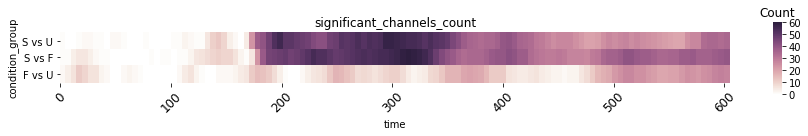

<Figure size 432x288 with 0 Axes>

In [2]:
# define the analysis target and extract them
script = {'conditions': 'S vs U:Scrambled&Unfamiliar,S vs F:Scrambled&Famous,F vs U:Famous&Unfamiliar',
          'timepoints': '0~600'}
e = epochs.extract(script)

# apply the algorithm
sig_ch_count = e.significant_channels_count(win_size='5ms')
# visualize the analyzed result
sig_ch_count.plot()
# # save the result for next time
# sig_ch_count.save('DATAS/EasyEEG_paper/sig_ch_count')

Result demo

In [38]:
# sig_ch_count = easyEEG.io.load_AnalyzedData('DATAS/EasyEEG_paper/sig_ch_count.pickle') 
# sig_ch_count.data # count
sig_ch_count

Name:  significant_channels_count

**Samples in Data:
time             2    7    12   17   22   27   32   37   42   47  ...   552  \
condition_group                                                   ...         
0 S vs U           1    0    0    1    2    2    1    1    0    2 ...    20   
0 S vs F           1    1    4    6    6    4    2    1    1    0 ...    36   
0 F vs U           2    4    7   12   10    7    7    3    2    0 ...    21   

time             557  562  567  572  577  582  587  592  597  
condition_group                                               
0 S vs U          20   25   27   27   34   35   35   34   35  
0 S vs F          38   38   39   37   37   37   38   39   40  
0 F vs U          23   25   24   23   25   26   28   29   28  

[3 rows x 120 columns]



### GFP
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the GFP result and significance in comparison
- Save the calculated result data into '.pickle' file
- Plot the result data

100% 30/30 [00:00<00:00, 243.71it/s]


Your file have been added ".pickle" as the extension name.
Result saved.


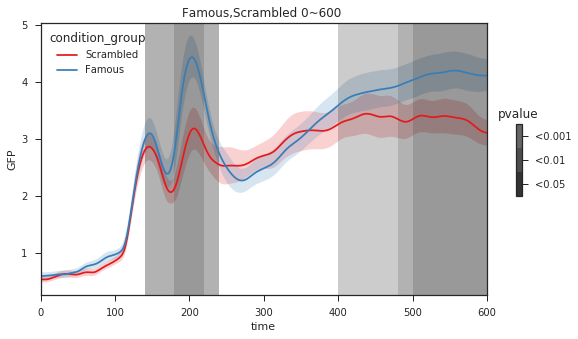

100% 30/30 [00:00<00:00, 248.01it/s]


Your file have been added ".pickle" as the extension name.
Result saved.


<Figure size 432x288 with 0 Axes>

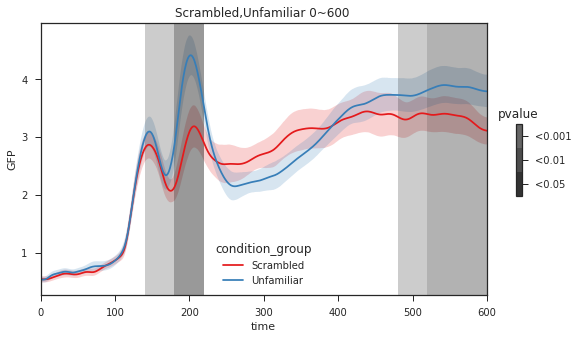

100% 30/30 [00:00<00:00, 254.32it/s]


Your file have been added ".pickle" as the extension name.
Result saved.


<Figure size 432x288 with 0 Axes>

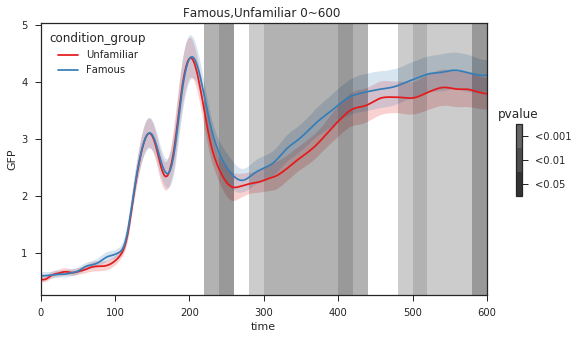

<Figure size 432x288 with 0 Axes>

In [6]:
scripts = [{'conditions': 'Scrambled,Famous',
                'timepoints': '0~600'},
           {'conditions': 'Scrambled,Unfamiliar',
                'timepoints': '0~600'},
           {'conditions': 'Unfamiliar,Famous',
                'timepoints': '0~600'}]

for idx,script in enumerate(scripts):
    gfp = epochs.extract(script).GFP(compare=True)
    gfp.default_plot_params['style']='ticks' # remove the backgroud color for paper publication
    gfp.plot()
#     gfp.save(f'DATAS/EasyEEG_paper/gfp{idx}')

Result demo

In [34]:
# gfp = easyEEG.io.load_AnalyzedData('DATAS/EasyEEG_paper/gfp0.pickle') 
# gfp.data # global field power
# gfp.annotation # pvalues
gfp

Name:  GFP

**Samples in Data:
time                                        0         1         2         3    \
subject condition_group channel_group                                           
1       0 Scrambled     0 All          0.377265  0.380017  0.384257  0.389661   
10      0 Scrambled     0 All          0.557882  0.555313  0.553497  0.552378   
11      0 Scrambled     0 All          0.515722  0.514311  0.513238  0.512541   
12      0 Scrambled     0 All          0.957178  0.964533  0.971517  0.977753   
13      0 Scrambled     0 All          0.508950  0.513307  0.519212  0.526837   

time                                        4         5         6         7    \
subject condition_group channel_group                                           
1       0 Scrambled     0 All          0.396364  0.403958  0.412531  0.421655   
10      0 Scrambled     0 All          0.552115  0.552640  0.554080  0.556310   
11      0 Scrambled     0 All          0.512792  0.513938  0.516386  0.519909

### TANOVA
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the TANOVA in different strategies (1,2,3)
- Save the calculated result data into '.pickle' file
- Plot the result data after correcting the multiple comparison issue

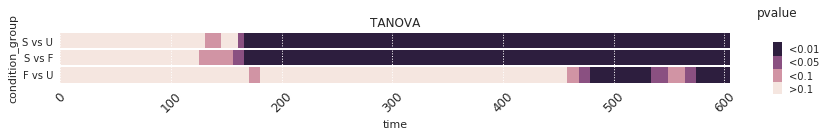

<Figure size 432x288 with 0 Axes>

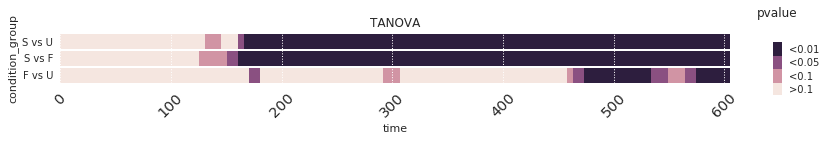

<Figure size 432x288 with 0 Axes>

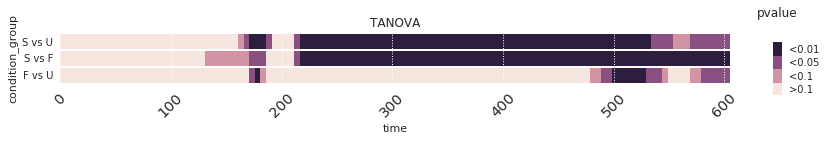

<Figure size 432x288 with 0 Axes>

In [4]:
script = {'conditions': 'S vs U:Scrambled&Unfamiliar,S vs F:Scrambled&Famous,F vs U:Famous&Unfamiliar',
          'timepoints': '0~600'}
e = epochs.extract(script)

t1 = e.tanova(win_size='5ms', shuffle=1000, strategy=1, parallel=True)
t2 = e.tanova(win_size='5ms', shuffle=1000, strategy=2, parallel=True)
t3 = e.tanova(win_size='5ms', shuffle=1000, strategy=3, parallel=True)

t1.correct(method='cluster').plot()
t2.correct(method='cluster').plot()
t3.correct(method='cluster').plot()

# t1.save('DATAS/EasyEEG_paper/tanova_mode1')
# t3.save('DATAS/EasyEEG_paper/tanova_mode3')
# t2.save('DATAS/EasyEEG_paper/tanova_mode2')

Result demo

In [33]:
# t1 = easyEEG.io.load_AnalyzedData('DATAS/EasyEEG_paper/tanova_mode1.pickle') 
# t1.data # pvalues
# t1.annotation # cosine distances
t1

Name:  TANOVA

**Samples in Data:
time                  2         7         12        17        22        27   \
condition_group                                                               
0 S vs U         0.556444  0.745255  0.664336  0.644356  0.813187  0.816184   
0 S vs F         0.617383  0.344655  0.222777  0.257742  0.453546  0.644356   
0 F vs U         0.784216  0.547453  0.369630  0.256743  0.239760  0.295704   

time                  32        37        42        47     ...          552  \
condition_group                                            ...                
0 S vs U         0.634366  0.528472  0.508492  0.434565    ...     0.000999   
0 S vs F         0.723277  0.729271  0.754246  0.850150    ...     0.000999   
0 F vs U         0.356643  0.315684  0.264735  0.273726    ...     0.090909   

time                  557       562       567       572       577       582  \
condition_group                                                               
0 S vs U        

### Classification
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the Classification result
- Save the calculated result data into '.pickle' file
- Plot the result data after correcting the multiple comparison issue

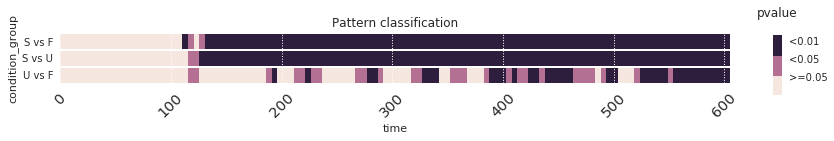

<Figure size 432x288 with 0 Axes>

In [7]:
script = {'conditions': 'S vs F:Scrambled&Famous,S vs U:Scrambled&Unfamiliar,U vs F:Unfamiliar&Famous',
          'timepoints': '0~600'}
e = epochs.extract(script)

c = e.classification(win_size='5ms',fold=25,parallel=False)
c.correct(method='cluster').plot()
# c.save('DATAS/EasyEEG_paper/classification')

In [1]:
import sys
sys.path = ['D:\Coding\py\py3\experiments\easyEEG_dist\\']+sys.path 

import easyEEG
c = easyEEG.io.load_AnalyzedData(r'D:\Doc\PhD_life_materials\easyEEG_paper\ms/classification.pickle') 

C:\app\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


EasyEEG loaded.


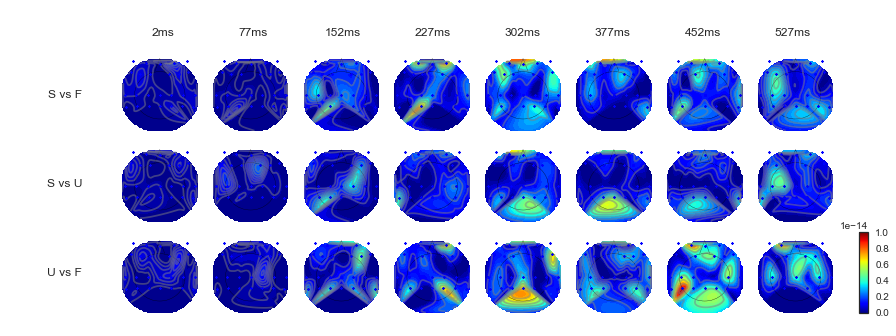

In [14]:
'plot the sensor weights (one topograph at each timepoints)'
# ** the figure will be too large if you have many timepoints **
easyEEG.graph.matrix_plot(data=c.supplement[0].iloc[:,::15], 
                          x_axis='time',
                          y_axis='condition_group',
                          plot_params=dict(plot_type=['matrix', 'topograph'],zlim=(0,1e-14)))

Result demo

In [32]:
# c = easyEEG.io.load_AnalyzedData('DATAS/EasyEEG_paper/classification.pickle') 
# c.data # pvalues
# c.annotation # scores
# c.supplement[0] # weights
c

Name:  Pattern classification

**Samples in Data:
time               2      7      12     17     22     27     32     37   \
condition_group                                                           
0 S vs F         0.256  0.641  0.718  0.952  0.898  0.852  0.885  0.728   
0 S vs U         0.232  0.343  0.787  0.929  0.904  0.867  0.540  0.497   
0 U vs F         0.037  0.192  0.492  0.668  0.615  0.732  0.566  0.636   

time               42     47  ...     552  557  562    567    572  577    582  \
condition_group               ...                                               
0 S vs F         0.857  0.951 ...   0.000  0.0  0.0  0.000  0.000  0.0  0.000   
0 S vs U         0.263  0.609 ...   0.000  0.0  0.0  0.000  0.000  0.0  0.000   
0 U vs F         0.306  0.401 ...   0.005  0.0  0.0  0.002  0.001  0.0  0.002   

time             587  592  597  
condition_group                 
0 S vs F         0.0  0.0  0.0  
0 S vs U         0.0  0.0  0.0  
0 U vs F         0.0  0.0  0.0  

[3

## Other common methods

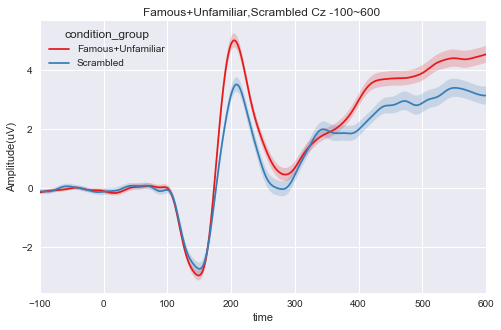

In [8]:
# ERP at Cz
script = {'conditions': 'Famous+Unfamiliar,Scrambled',
          'channels': 'Cz',
          'timepoints': '-100~600'}
epochs.extract(script).ERP().plot()

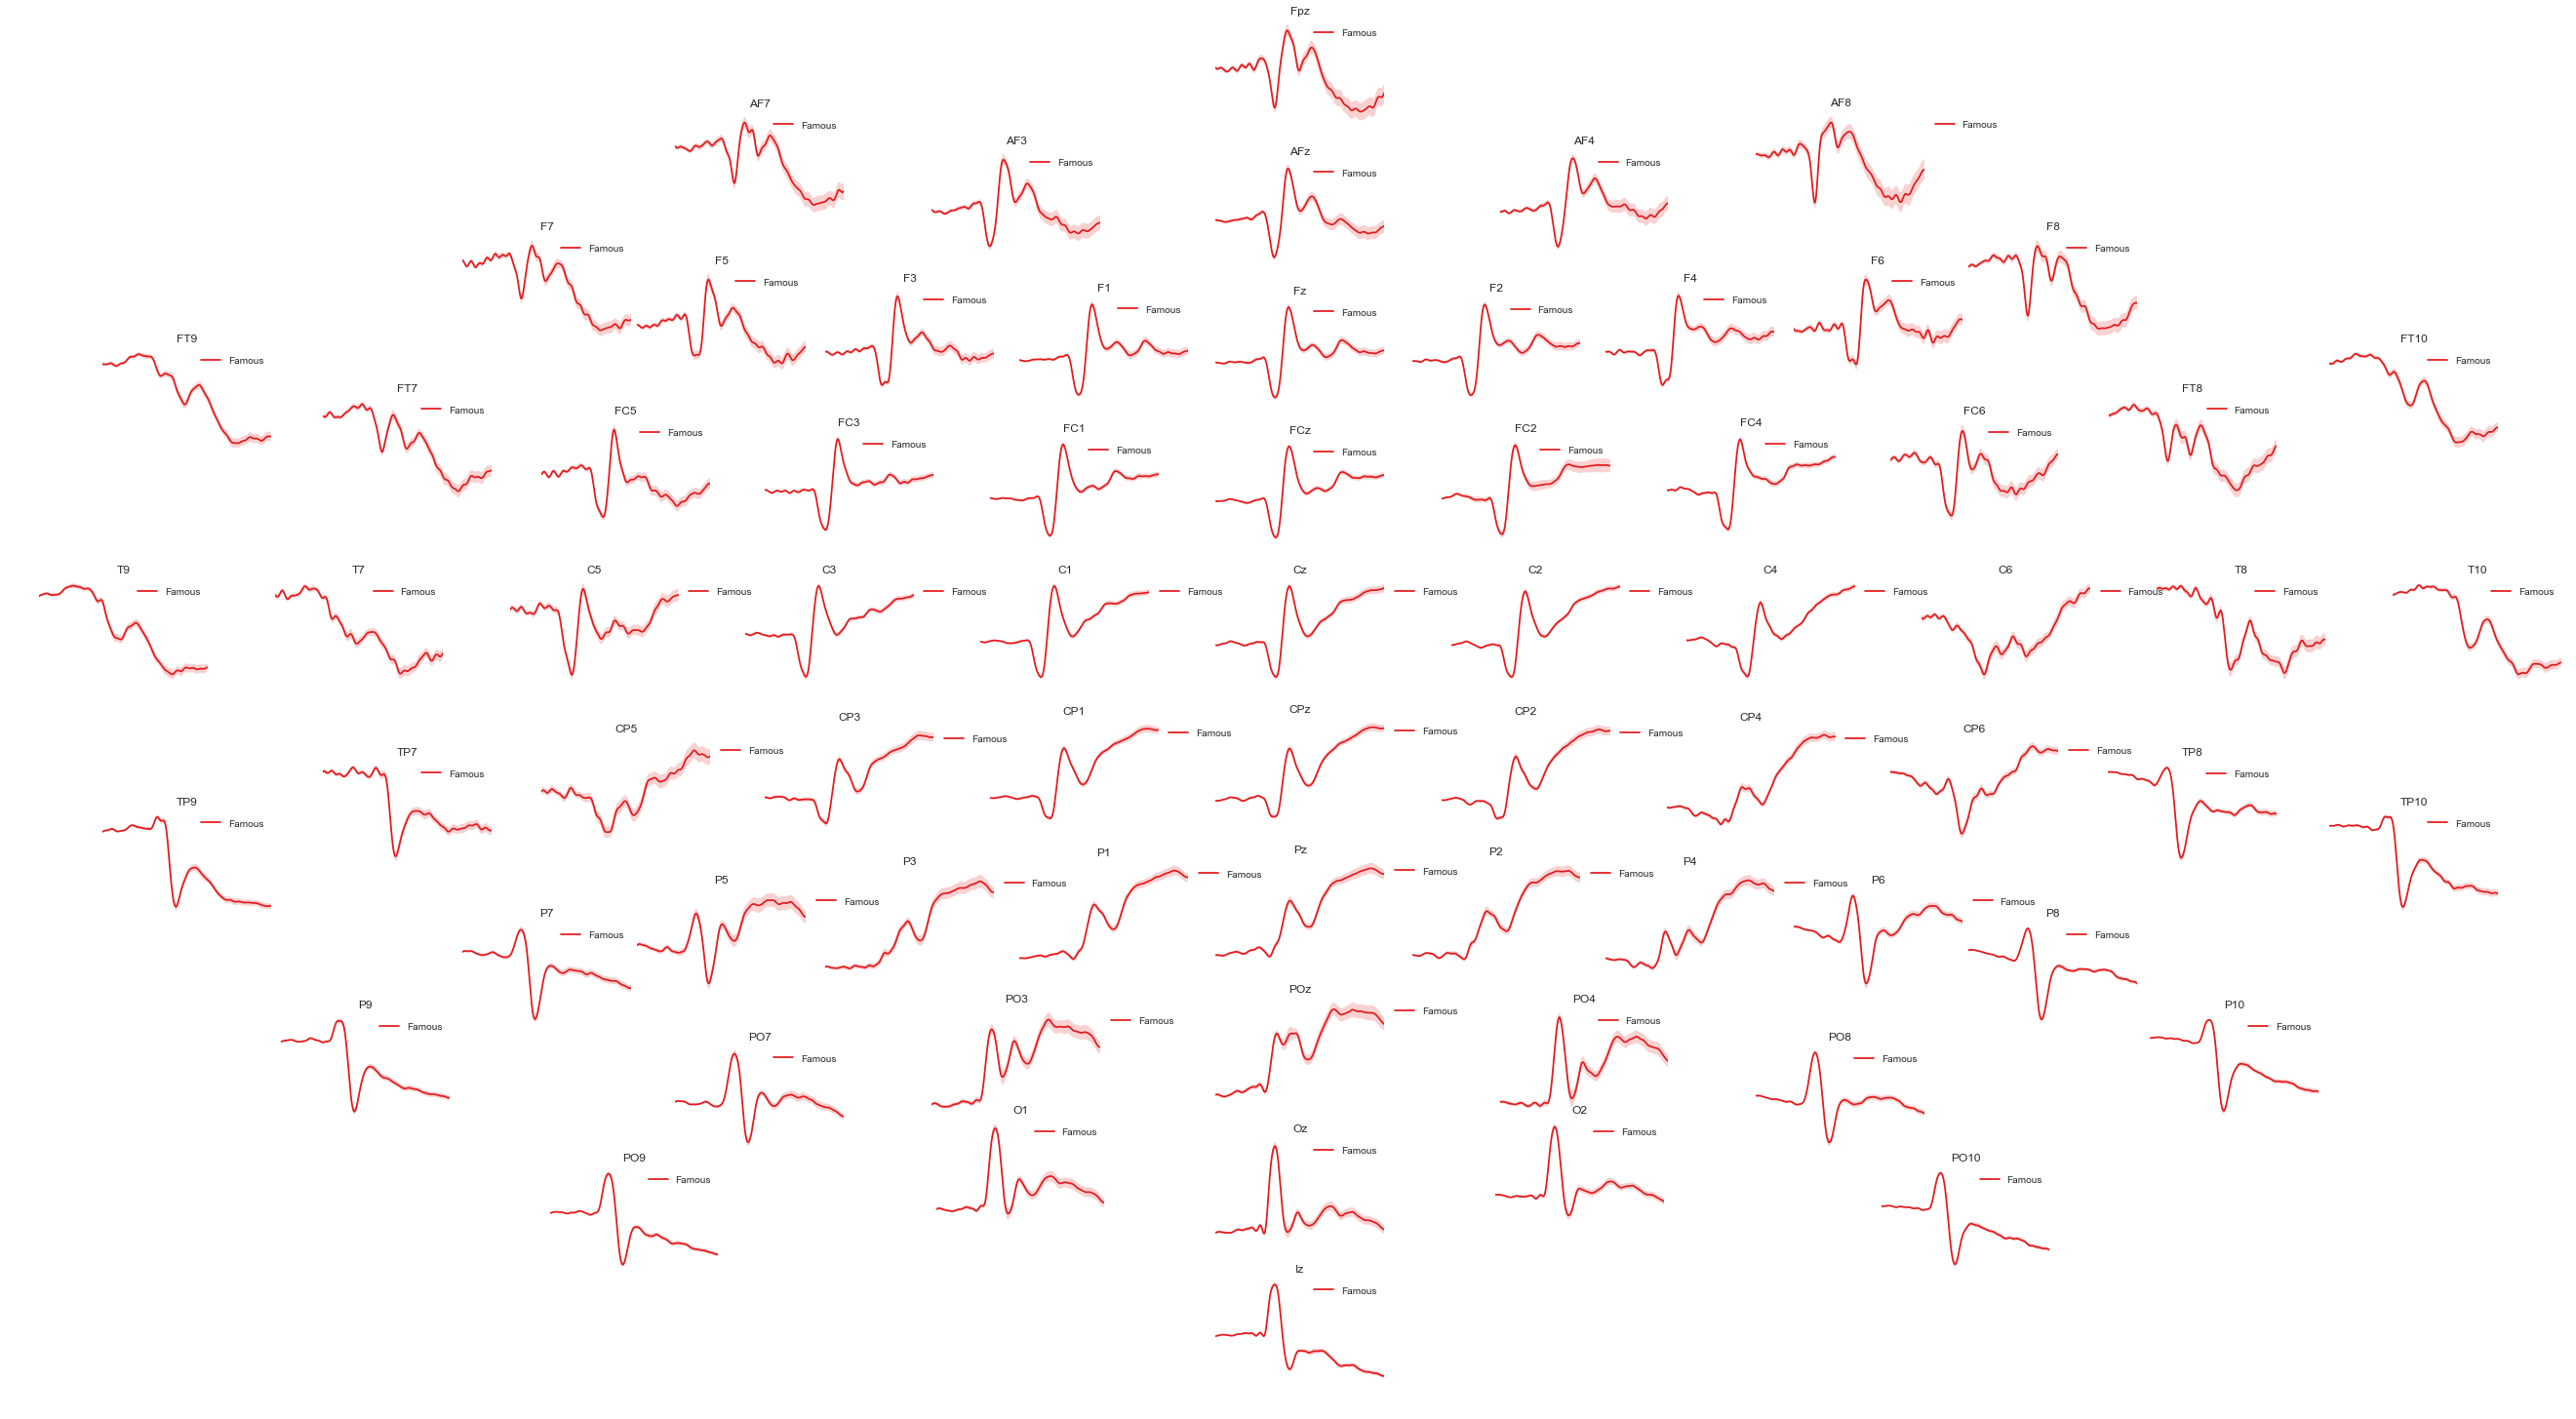

In [19]:
# ERP at all sensors
script = {'conditions': 'Famous',
          'channels': 'each',
          'timepoints': '-100~600'}
epochs.extract(script).topo_ERPs().plot()

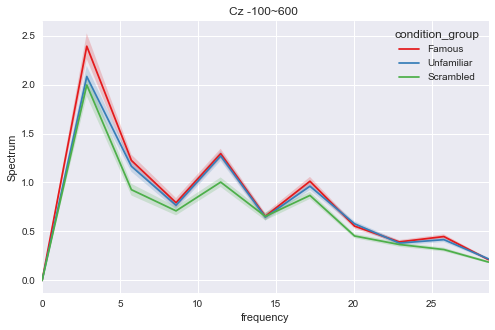

In [12]:
# Spectrum
script = {'conditions': 'Famous,Unfamiliar,Scrambled',
          'channels': 'Cz',
          'timepoints': '0~600'}
epochs.extract(script).Spectrum().plot() # default parameter: freq_span=(0,30)

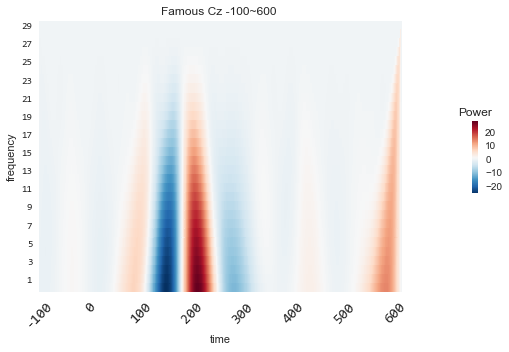

In [14]:
# Time-frequency 
script = {'conditions': 'Famous',
          'channels': 'Cz',
          'timepoints': '-100~600'}
epochs.extract(script).Time_frequency().plot() # default parameter: freq_span=(0,30)

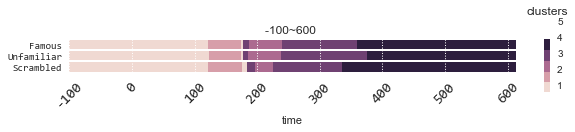

In [15]:
# Temporal&conditional distribution of the clustering result of all the data samples
script = {'conditions': 'Famous,Unfamiliar,Scrambled',
          'timepoints': '-100~600'}
epochs.extract(script).clustering(n_clusters=5).plot()

In [ ]:
## Deep Learning model (CNN) for classification

from EasyEEG.graph.figure_unit import get_topograph

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.layers import Reshape, MaxPooling2D, Conv2D, Dense, Flatten
from tensorflow.python.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score


# transform the feature vector (amplitudes) to a feature matrix (topography)  
def reshape_X(X, extra_params):
    N = 20
    locs = epochs.info['xy_locs']
    channels = X[0].columns.get_level_values('channel')
    
    X = np.array([get_topograph(i, locs, channels, N) for i in X])
    return X

# define a CNN model  
def run_model(X, Y, train_index, test_index, extra_params):
    # model structure (https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/03C_Keras_API.ipynb) 
    img_size = 20
    
    model = Sequential()
    
    model.add(Reshape((img_size, img_size, 1), input_shape=(img_size, img_size)))
    
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
   
    model.add(Flatten()) # Flatten the 4-rank output of the convolutional layers to 2-rank that can be input to a fully connected layer.
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax')) # Last fully connected layer with softmax-activation，for the classification
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-2))
    
    # model trainning
    model.fit(x=X[train_index], y=to_categorical(Y)[train_index], batch_size=30, epochs=1, verbose=0)
    
    # model inference
    prob_train = model.predict_proba(X[train_index])[:,1]
    prob_test = model.predict_proba(X[test_index])[:,1]


    # generate AUC as the classification score 
    score_train = roc_auc_score(Y[train_index],prob_train)
    score_test = roc_auc_score(Y[test_index],prob_test)
    
    return score_train, score_test


result = e.classification(win_size='10ms',fold=15,
                          reshape_X_method=reshape_X,
                          run_model=run_model)
result.correct(method='cluster').plot()